## natural langauge


In [66]:
plt.rcParams["font.family"] = "Times New Roman"

# Define the paths and parameters directly for notebook usage
# exp_name = "BLLIP_SM"
exp_name = "babylm2024_100K_sents"

# results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test.csv"
results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test_mlocal_entropy.csv"

output_dir = "plots"
architectures = ["transformer", "lstm"]
architecture_labels = ["Transformer", "LSTM"]
split_name = "test"

df = pd.read_csv(results_path)
df["experiment_name"] = df["grammar_name"].apply(get_experiment_name)
df["seed"] = df["grammar_name"].apply(get_seed)
df["window"] = df["grammar_name"].apply(get_window)

architecture_map = dict(zip(architectures, architecture_labels))

In [67]:
# Calculate local entropy statistics for LocalShuffle by window size
df["window"] = df["grammar_name"].apply(get_window)
local_shuffle_stats = (
    df[df["grammar_name"].str.contains("LocalShuffle")]
    .groupby("window")
    .agg(
        {
            "2_local_entropy": ["mean", "std"],
            "3_local_entropy": ["mean", "std"],
            "4_local_entropy": ["mean", "std"],
            "5_local_entropy": ["mean", "std"],
        }
    )
    .round(2)
)

# Create LocalShuffle rows for each window size
local_shuffle_rows = pd.DataFrame(
    {
        col: [
            f"{local_shuffle_stats.loc[window][col]['mean']} ± {local_shuffle_stats.loc[window][col]['std']}"
            for window in local_shuffle_stats.index
        ]
        for col in [
            "2_local_entropy",
            "3_local_entropy",
            "4_local_entropy",
            "5_local_entropy",
        ]
    },
    index=[f"LocalShuffle (k={window})" for window in local_shuffle_stats.index],
)

# Calculate other experiments
other_exps_mask = df["grammar_name"].str.contains(
    "Base|EvenOddShuffle|Reverse|DeterministicShuffle|OddEvenShuffle"
)
other_exps = (
    df[other_exps_mask]
    .groupby(df["grammar_name"].apply(lambda x: x.split("_")[0]))[
        ["2_local_entropy", "3_local_entropy", "4_local_entropy", "5_local_entropy"]
    ]
    .mean()
    .round(2)
)

latex_df = pd.concat([local_shuffle_rows, other_exps])
latex_df.columns = ["2-local", "3-local", "4-local", "5-local"]

print(
    latex_df.to_latex(
        escape=False,
        caption="M-local entropy values for different experimental conditions. LocalShuffle values are shown as mean ± standard deviation for each window size k.",
        label="tab:local_entropy",
    )
)

\begin{table}
\caption{M-local entropy values for different experimental conditions. LocalShuffle values are shown as mean ± standard deviation for each window size k.}
\label{tab:local_entropy}
\begin{tabular}{lllll}
\toprule
 & 2-local & 3-local & 4-local & 5-local \\
\midrule
LocalShuffle (k=3.0) & 6.99 ± 0.16 & 4.27 ± 0.08 & 3.21 ± 0.07 & 2.97 ± 0.08 \\
LocalShuffle (k=4.0) & 7.09 ± 0.15 & 4.35 ± 0.06 & 3.25 ± 0.03 & 3.06 ± 0.04 \\
LocalShuffle (k=5.0) & 7.15 ± 0.13 & 4.42 ± 0.06 & 3.29 ± 0.04 & 3.08 ± 0.03 \\
LocalShuffle (k=6.0) & 7.25 ± 0.11 & 4.47 ± 0.07 & 3.35 ± 0.06 & 3.14 ± 0.05 \\
LocalShuffle (k=7.0) & 7.28 ± 0.12 & 4.5 ± 0.08 & 3.39 ± 0.07 & 3.19 ± 0.08 \\
Base & 5.780000 & 3.720000 & 2.690000 & 2.320000 \\
DeterministicShuffle & 7.410000 & 4.690000 & 3.590000 & 3.400000 \\
EvenOddShuffle & 6.820000 & 4.470000 & 3.360000 & 3.140000 \\
OddEvenShuffle & 6.940000 & 4.450000 & 3.390000 & 3.140000 \\
Reverse & 6.500000 & 3.870000 & 2.780000 & 2.430000 \\
\bottomrule
\end{tabul

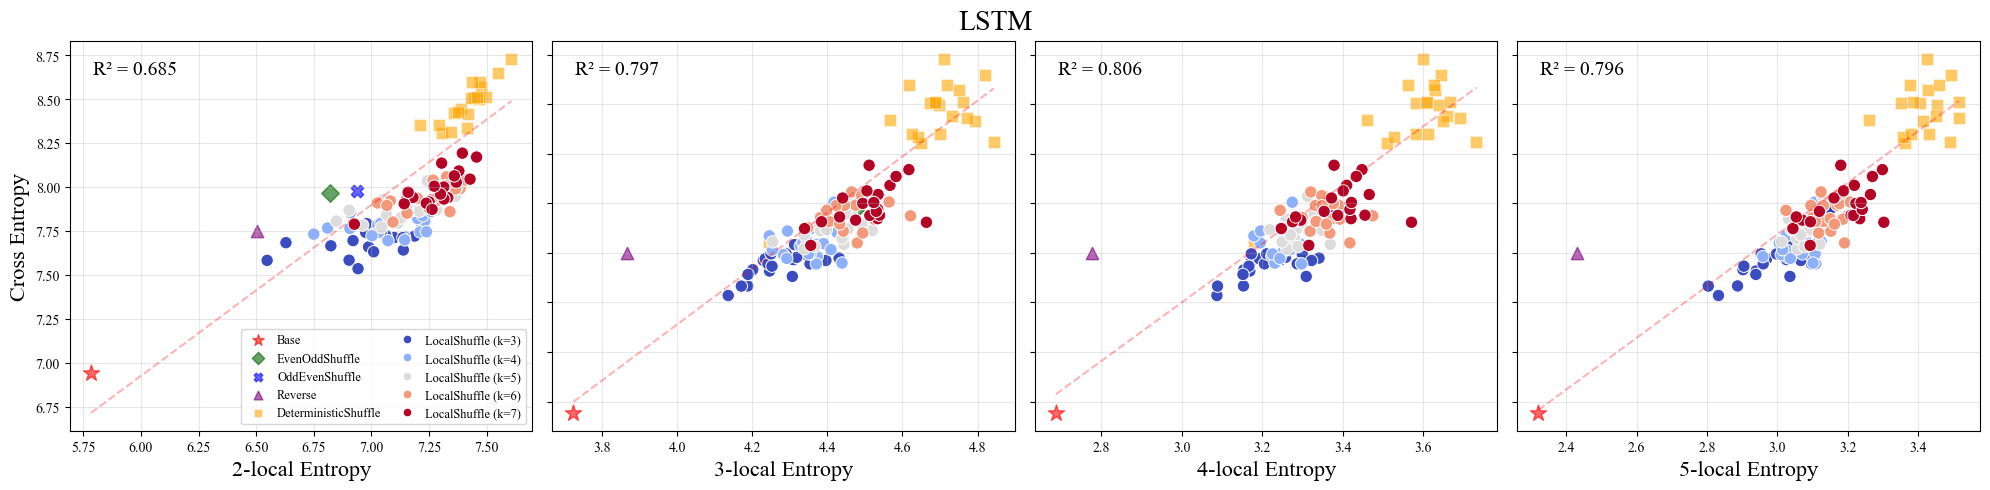

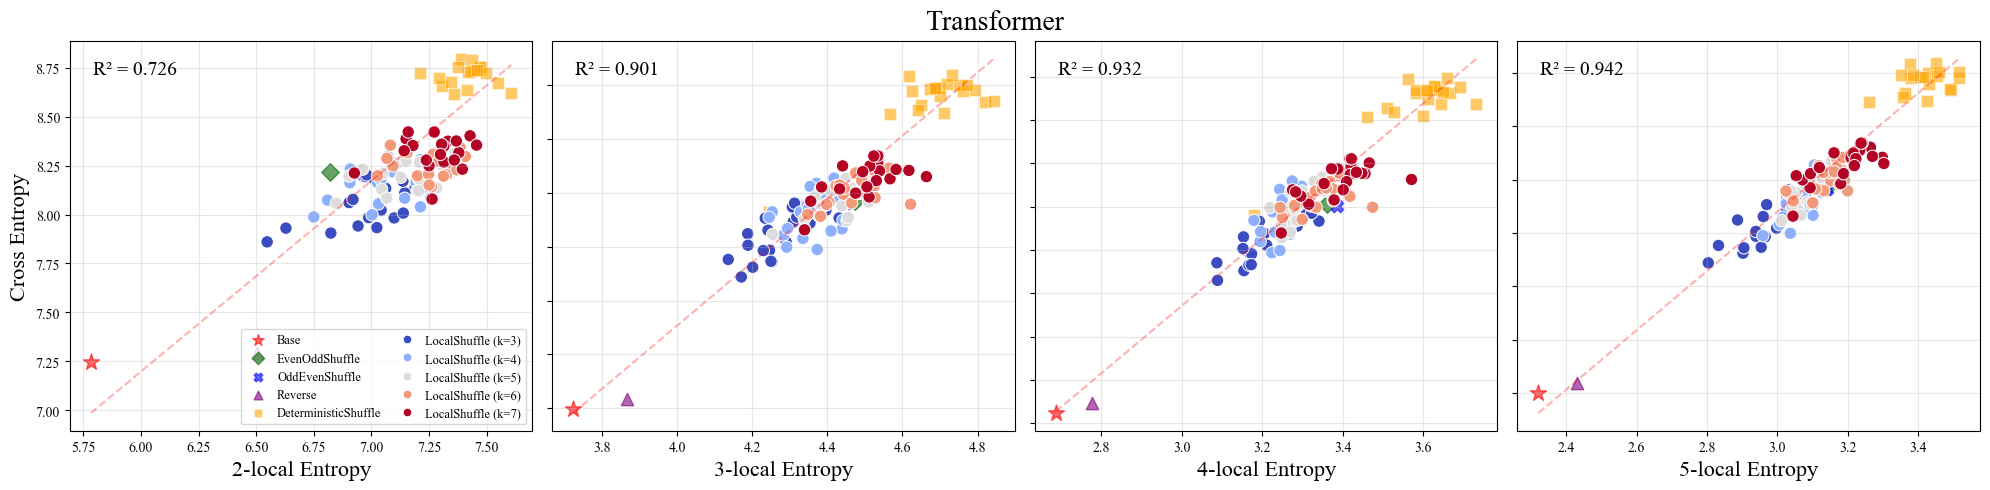

In [68]:
# Plot correlation between local entropy and cross entropy for each architecture
n_grams = [col.split("_")[0] for col in df.columns if col.endswith("_local_entropy")]
marker_map = {
    "LocalShuffle": "o",
    "DeterministicShuffle": "s",
    "Reverse": "^",
    "EvenOddShuffle": "D",
    "OddEvenShuffle": "X",
    "Base": "*",
}
color_map = {
    "Base": "red",
    "EvenOddShuffle": "darkgreen",
    "OddEvenShuffle": "blue",
    "Reverse": "purple",
    "DeterministicShuffle": "orange",
}

for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]
    fig, axes = plt.subplots(
        1, len(n_grams), figsize=(5 * len(n_grams), 6)
    )  # 高さを5から6に変更

    for i, n_gram in enumerate(n_grams):
        # Plot base experiments
        for exp_name in ["Base", "EvenOddShuffle", "OddEvenShuffle", "Reverse"]:
            exp_data = model_data[model_data["experiment_name"] == exp_name]
            if not exp_data.empty:
                # Average across training seeds for each grammar
                exp_data_mean = (
                    exp_data.groupby("grammar_name")
                    .agg(
                        {
                            f"{n_gram}_local_entropy": "mean",
                            "cross_entropy_per_token_base_2": "mean",
                        }
                    )
                    .reset_index()
                )

                axes[i].scatter(
                    exp_data_mean[f"{n_gram}_local_entropy"],
                    exp_data_mean["cross_entropy_per_token_base_2"],
                    marker=marker_map[exp_name],
                    color=color_map[exp_name],
                    s=150 if exp_name == "Base" else 80,
                    alpha=0.6,
                    label=exp_name,
                )

        # Plot DeterministicShuffle
        det_data = model_data[model_data["experiment_name"] == "DeterministicShuffle"]
        if not det_data.empty:
            det_data_mean = (
                det_data.groupby("grammar_name")
                .agg(
                    {
                        f"{n_gram}_local_entropy": "mean",
                        "cross_entropy_per_token_base_2": "mean",
                    }
                )
                .reset_index()
            )

            axes[i].scatter(
                det_data_mean[f"{n_gram}_local_entropy"],
                det_data_mean["cross_entropy_per_token_base_2"],
                marker=marker_map["DeterministicShuffle"],
                color=color_map["DeterministicShuffle"],
                s=80,
                alpha=0.6,
                edgecolor="white",
                linewidth=0.5,
                label="DeterministicShuffle",
            )

        # Plot LocalShuffle
        local_data = model_data[
            model_data["experiment_name"].str.contains("LocalShuffle", na=False)
        ]
        if not local_data.empty:
            local_data_mean = (
                local_data.groupby(["window", "grammar_name"])
                .agg(
                    {
                        f"{n_gram}_local_entropy": "mean",
                        "cross_entropy_per_token_base_2": "mean",
                    }
                )
                .reset_index()
            )

            sns.scatterplot(
                data=local_data_mean,
                x=f"{n_gram}_local_entropy",
                y="cross_entropy_per_token_base_2",
                hue="window",
                marker=marker_map["LocalShuffle"],
                ax=axes[i],
                palette="coolwarm",
                s=80,
            )

        # Add regression line and R² value
        all_data = pd.concat(
            [
                model_data[model_data["experiment_name"] == exp_name][
                    [f"{n_gram}_local_entropy", "cross_entropy_per_token_base_2"]
                ]
                for exp_name in [
                    "Base",
                    "EvenOddShuffle",
                    "OddEvenShuffle",
                    "Reverse",
                    "DeterministicShuffle",
                ]
            ]
            + [
                local_data_mean[
                    [f"{n_gram}_local_entropy", "cross_entropy_per_token_base_2"]
                ]
            ]
            if not local_data.empty
            else []
        )

        if not all_data.empty:
            x = all_data[f"{n_gram}_local_entropy"]
            y = all_data["cross_entropy_per_token_base_2"]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.array([x.min(), x.max()])
            line_y = slope * line_x + intercept
            axes[i].plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)
            axes[i].text(
                0.05,
                0.95,
                f"R² = {r_value**2:.3f}",
                transform=axes[i].transAxes,
                verticalalignment="top",
                fontsize=14,
            )

        axes[i].set_xlabel(f"{n_gram}-local Entropy", fontsize=16)
        axes[i].set_ylabel("Cross Entropy" if i == 0 else "", fontsize=16)
        axes[i].grid(True, alpha=0.3)

        # Get legend handles and labels
        handles, labels = axes[i].get_legend_handles_labels()
        if not local_data.empty:
            n_windows = len(local_data["window"].unique())
            window_labels = [
                f"LocalShuffle (k={int(w)})"
                for w in sorted(local_data["window"].unique())
            ]
            labels = labels[:-n_windows] + window_labels

        if i > 0:
            axes[i].yaxis.set_ticklabels([])
            if axes[i].get_legend() is not None:
                axes[i].get_legend().remove()
        else:
            # legendの位置を調整
            axes[i].legend(
                handles,
                labels,
                loc="lower right",
                fontsize=9,
                markerscale=0.7,
                handletextpad=0.5,
                labelspacing=0.5,
                bbox_to_anchor=(1.0, 0.0),  # -0.15から-0.1に変更
                ncol=2,
                columnspacing=1.0,
            )

    plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.91)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # 下部の余白を0.05から0.1に増加
    plt.show()

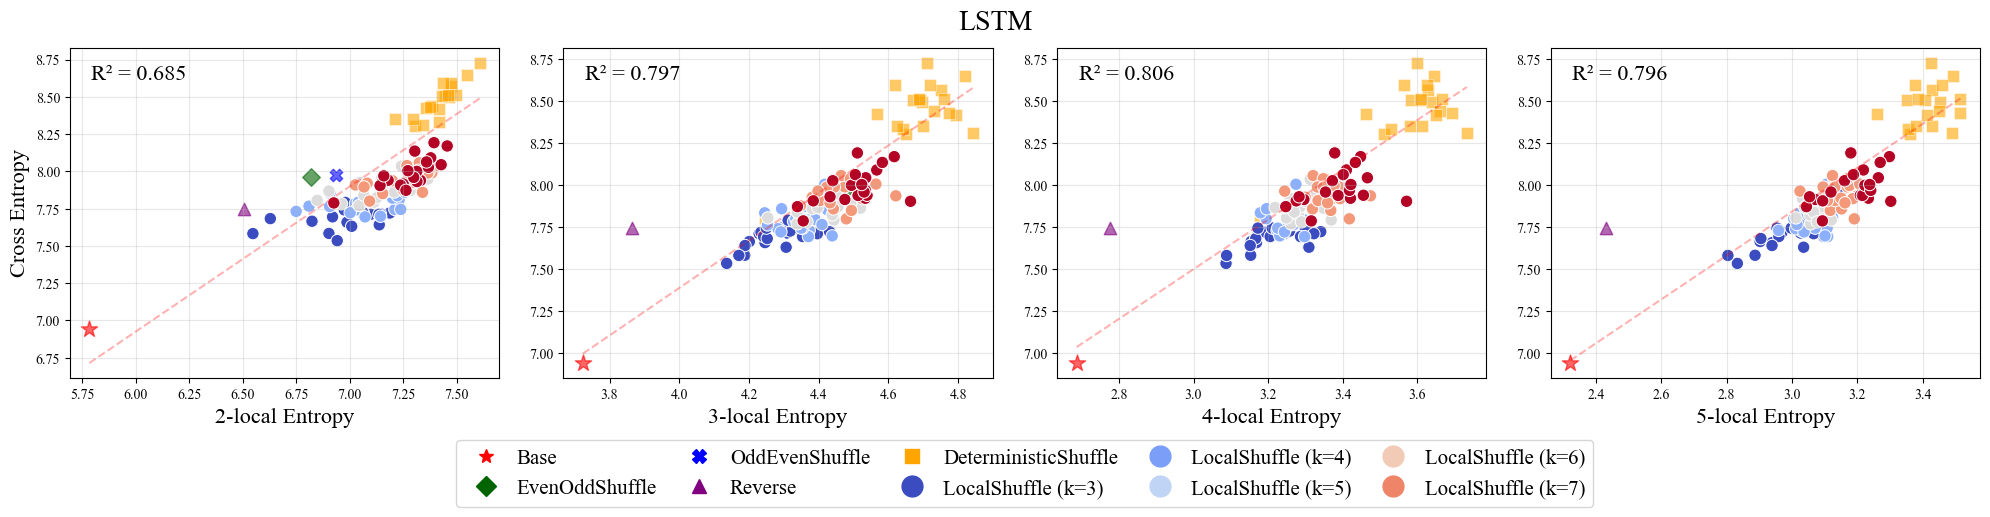

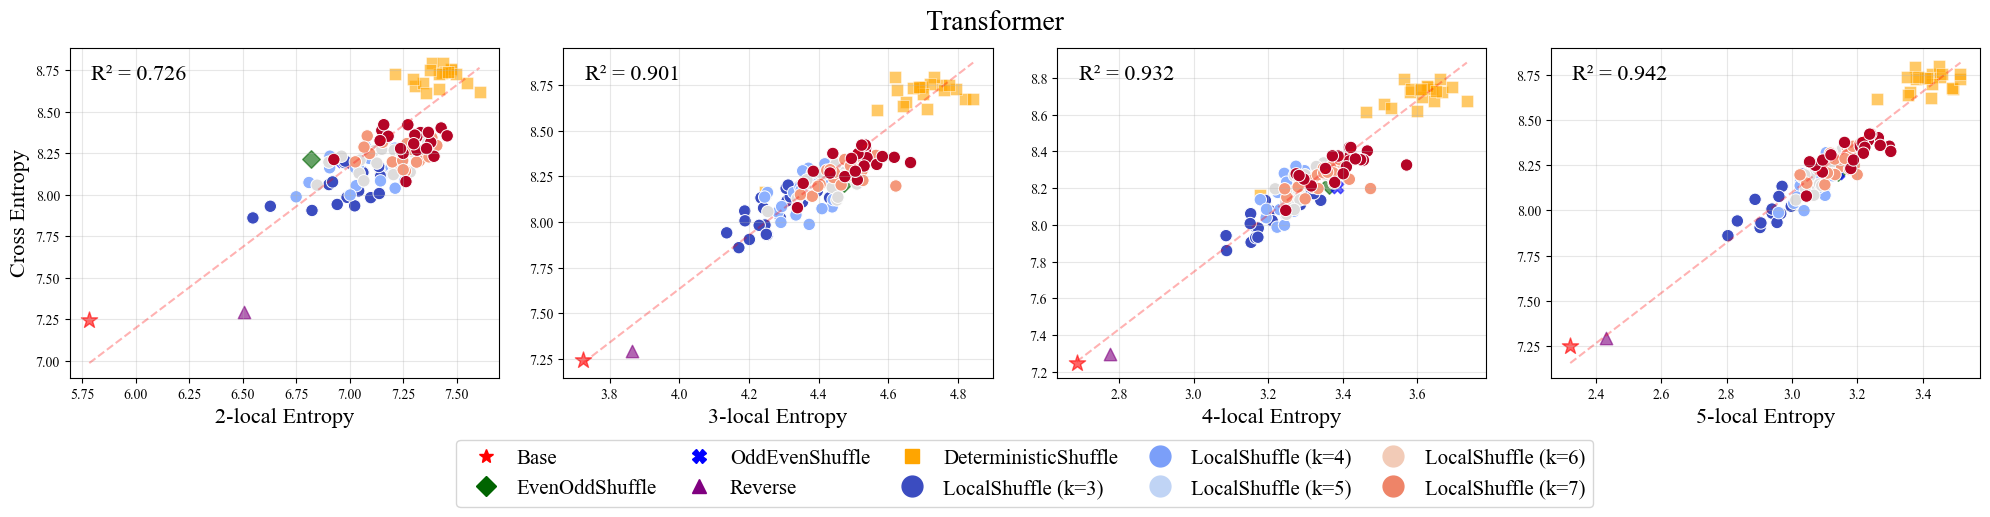

In [69]:
# Plot correlation between local entropy and cross entropy for each architecture
n_grams = [col.split("_")[0] for col in df.columns if col.endswith("_local_entropy")]
marker_map = {
    "LocalShuffle": "o",
    "DeterministicShuffle": "s",
    "Reverse": "^",
    "EvenOddShuffle": "D",
    "OddEvenShuffle": "X",
    "Base": "*",
}
color_map = {
    "Base": "red",
    "EvenOddShuffle": "darkgreen",
    "OddEvenShuffle": "blue",
    "Reverse": "purple",
    "DeterministicShuffle": "orange",
}

for architecture in df["architecture"].unique():
    # Create figure with GridSpec to manage subplot layout
    fig = plt.figure(figsize=(5 * len(n_grams), 6))  # 高さを7から6に変更

    # Create 2 rows - top for plots, bottom for legend
    gs = fig.add_gridspec(2, 1, height_ratios=[6, 1])  # プロットと判例の比率を調整

    # Create subplot grid for the top plots
    gs_top = gs[0].subgridspec(1, len(n_grams), wspace=0.15)
    axes = [fig.add_subplot(gs_top[0, i]) for i in range(len(n_grams))]

    model_data = df[df["architecture"] == architecture]

    for i, n_gram in enumerate(n_grams):
        # Plot base experiments
        for exp_name in ["Base", "EvenOddShuffle", "OddEvenShuffle", "Reverse"]:
            exp_data = model_data[model_data["experiment_name"] == exp_name]
            if not exp_data.empty:
                # Average across training seeds for each grammar
                exp_data_mean = (
                    exp_data.groupby("grammar_name")
                    .agg(
                        {
                            f"{n_gram}_local_entropy": "mean",
                            "cross_entropy_per_token_base_2": "mean",
                        }
                    )
                    .reset_index()
                )

                axes[i].scatter(
                    exp_data_mean[f"{n_gram}_local_entropy"],
                    exp_data_mean["cross_entropy_per_token_base_2"],
                    marker=marker_map[exp_name],
                    color=color_map[exp_name],
                    s=150 if exp_name == "Base" else 80,
                    alpha=0.6,
                    label=exp_name,
                )

        # Plot DeterministicShuffle
        det_data = model_data[model_data["experiment_name"] == "DeterministicShuffle"]
        if not det_data.empty:
            det_data_mean = (
                det_data.groupby("grammar_name")
                .agg(
                    {
                        f"{n_gram}_local_entropy": "mean",
                        "cross_entropy_per_token_base_2": "mean",
                    }
                )
                .reset_index()
            )

            axes[i].scatter(
                det_data_mean[f"{n_gram}_local_entropy"],
                det_data_mean["cross_entropy_per_token_base_2"],
                marker=marker_map["DeterministicShuffle"],
                color=color_map["DeterministicShuffle"],
                s=80,
                alpha=0.6,
                edgecolor="white",
                linewidth=0.5,
                label="DeterministicShuffle",
            )

        # Plot LocalShuffle
        local_data = model_data[
            model_data["experiment_name"].str.contains("LocalShuffle", na=False)
        ]
        if not local_data.empty:
            local_data_mean = (
                local_data.groupby(["window", "grammar_name"])
                .agg(
                    {
                        f"{n_gram}_local_entropy": "mean",
                        "cross_entropy_per_token_base_2": "mean",
                    }
                )
                .reset_index()
            )

            sns.scatterplot(
                data=local_data_mean,
                x=f"{n_gram}_local_entropy",
                y="cross_entropy_per_token_base_2",
                hue="window",
                marker=marker_map["LocalShuffle"],
                ax=axes[i],
                palette="coolwarm",
                s=80,
            )

        # Add regression line and R² value
        all_data = pd.concat(
            [
                model_data[model_data["experiment_name"] == exp_name][
                    [f"{n_gram}_local_entropy", "cross_entropy_per_token_base_2"]
                ]
                for exp_name in [
                    "Base",
                    "EvenOddShuffle",
                    "OddEvenShuffle",
                    "Reverse",
                    "DeterministicShuffle",
                ]
            ]
            + [
                local_data_mean[
                    [f"{n_gram}_local_entropy", "cross_entropy_per_token_base_2"]
                ]
            ]
            if not local_data.empty
            else []
        )

        if not all_data.empty:
            x = all_data[f"{n_gram}_local_entropy"]
            y = all_data["cross_entropy_per_token_base_2"]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.array([x.min(), x.max()])
            line_y = slope * line_x + intercept
            axes[i].plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)
            axes[i].text(
                0.05,
                0.95,
                f"R² = {r_value**2:.3f}",
                transform=axes[i].transAxes,
                verticalalignment="top",
                fontsize=16,
            )

        axes[i].set_xlabel(f"{n_gram}-local Entropy", fontsize=16)
        axes[i].set_ylabel("Cross Entropy" if i == 0 else "", fontsize=16)
        axes[i].grid(True, alpha=0.3)

        # Remove individual legends from plots
        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()

    # Add combined legend at the bottom
    legend_ax = fig.add_subplot(gs[1])
    legend_ax.axis("off")

    # Create all legend elements
    legend_elements = []

    # Add base elements (first row)
    legend_elements.extend(
        [
            plt.Line2D(
                [0],
                [0],
                marker=marker_map[exp],
                color=color_map[exp],
                markersize=10,
                linestyle="None",
                label=exp,
            )
            for exp in [
                "Base",
                "EvenOddShuffle",
                "OddEvenShuffle",
                "Reverse",
                "DeterministicShuffle",
            ]
        ]
    )

    # Add LocalShuffle elements (second row)
    if "local_data" in locals() and not local_data.empty:
        windows = sorted(local_data["window"].unique())
        legend_elements.extend(
            [
                plt.Line2D(
                    [0],
                    [0],
                    marker=marker_map["LocalShuffle"],
                    color=plt.cm.coolwarm(i / len(windows)),
                    markersize=15,
                    linestyle="None",
                    label=f"LocalShuffle (k={int(w)})",
                )
                for i, w in enumerate(windows)
            ]
        )

    legend = legend_ax.legend(
        handles=legend_elements,
        loc="center",
        bbox_to_anchor=(0.5, 0.5),
        ncol=5,
        fontsize=15,
        handletextpad=0.5,
        columnspacing=1.0,
        labelspacing=0.5,
    )  # 行間を縮小

    plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.90)
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # 余白を調整
    plt.show()

## PFSA


In [77]:
import matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import argparse
from pathlib import Path
from scipy import stats


def get_experiment_name(x):
    """Extract experiment name from grammar name."""
    return x.split("_")[0]


def get_seed(x):
    """Extract seed from grammar name if it exists."""
    if "seed" in x:
        return int(re.search(r"seed(\d+)", x).group(1))
    return None


def get_window(x):
    """Extract window size from grammar name if it exists."""
    if "window" in x:
        return int(re.search(r"window(\d+)", x).group(1))
    return None


def plot_entropy_distributions(df):
    """Plot local and global entropy distributions."""
    # Prepare data
    local_entropy_cols = [f"{m}_local_entropy" for m in [2, 3, 4, 5]]
    local_entropy_data = df[local_entropy_cols]
    global_entropy_data = df[["next_symbol_entropy"]]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot local entropy distributions
    sns.swarmplot(data=local_entropy_data, ax=ax1, size=8, alpha=0.6)
    sns.boxplot(
        data=local_entropy_data,
        ax=ax1,
        color="white",
        width=0.3,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )

    # Plot global entropy distribution
    sns.swarmplot(data=global_entropy_data, ax=ax2, size=8, alpha=0.6)
    sns.boxplot(
        data=global_entropy_data,
        ax=ax2,
        color="white",
        width=0.3,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )

    # Customize plots
    ax1.set_xticklabels(
        ["2-local Entropy", "3-local Entropy", "4-local Entropy", "5-local Entropy"],
        fontsize=12,
        color="black",
    )
    ax1.set_ylabel("Entropy Value", fontsize=12)
    ax1.set_title("Local Entropy Distributions", fontsize=14)
    ax1.grid(True, alpha=0.3)

    ax2.set_xticklabels(["Global Entropy"], fontsize=12)
    ax2.set_ylabel("Entropy Value", fontsize=12)
    ax2.set_title("Global Entropy Distribution", fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Print statistics
    print("\nLocal Entropy Statistics:")
    print(local_entropy_data.describe())
    print("\nGlobal Entropy Statistics:")
    print(global_entropy_data.describe())

    return fig


def plot_local_entropy_vs_cross_entropy(df, architecture_map):
    """Plot local entropy vs cross entropy with regression lines for each architecture."""
    # Get m values from column names
    ms = [
        int(col.replace("_local_entropy", ""))
        for col in df.columns
        if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
    ]

    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplots
        fig, axes = plt.subplots(1, len(ms), figsize=(5 * len(ms), 5))

        for i, m in enumerate(ms):
            # Average across training seeds
            model_data_mean = (
                model_data.groupby("grammar_name")
                .agg(
                    {
                        f"{m}_local_entropy": "mean",
                        "cross_entropy_per_token_base_2": "mean",
                    }
                )
                .reset_index()
            )

            sns.scatterplot(
                data=model_data_mean,
                x=f"{m}_local_entropy",
                y="cross_entropy_per_token_base_2",
                ax=axes[i],
                s=100,
                color="blue",
            )

            # Add regression line
            x = model_data_mean[f"{m}_local_entropy"]
            y = model_data_mean["cross_entropy_per_token_base_2"]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.array([x.min(), x.max()])
            line_y = slope * line_x + intercept
            axes[i].plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

            # Add R² value
            r_squared = r_value**2
            axes[i].text(
                0.05,
                0.95,
                f"R² = {r_squared:.3f}",
                transform=axes[i].transAxes,
                verticalalignment="top",
                fontsize=14,
            )

            axes[i].set_xlabel(f"{m}-local Entropy", fontsize=16)
            axes[i].set_ylabel("Cross Entropy" if i == 0 else "", fontsize=16)
            axes[i].grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.9)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_local_entropy_vs_kl_divergence(df, architecture_map):
    """Plot local entropy vs KL divergence with regression lines for each architecture."""
    # Get m values from column names
    ms = [
        int(col.replace("_local_entropy", ""))
        for col in df.columns
        if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
    ]

    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplots
        fig, axes = plt.subplots(1, len(ms), figsize=(5 * len(ms), 5))

        for i, m in enumerate(ms):
            # Average across training seeds
            model_data_mean = (
                model_data.groupby("grammar_name")
                .agg(
                    {
                        f"{m}_local_entropy": "mean",
                        "KL_divergence": "mean",
                    }
                )
                .reset_index()
            )

            sns.scatterplot(
                data=model_data_mean,
                x=f"{m}_local_entropy",
                y="KL_divergence",
                ax=axes[i],
                s=100,
                color="blue",
            )

            # Add regression line
            x = model_data_mean[f"{m}_local_entropy"]
            y = model_data_mean["KL_divergence"]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            line_x = np.array([x.min(), x.max()])
            line_y = slope * line_x + intercept
            axes[i].plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

            # Add R² value
            r_squared = r_value**2
            axes[i].text(
                0.05,
                0.95,
                f"R² = {r_squared:.3f}",
                transform=axes[i].transAxes,
                verticalalignment="top",
                fontsize=14,
            )

            axes[i].set_xlabel(f"{m}-local Entropy", fontsize=16)
            axes[i].set_ylabel("KL Divergence" if i == 0 else "", fontsize=16)
            axes[i].grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.9)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_next_sym_global_entropy_vs_cross_entropy(df, architecture_map):
    """Plot next symbol (global) entropy vs cross entropy with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "next_symbol_entropy": "mean",
                    "cross_entropy_per_token_base_2": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="next_symbol_entropy",
            y="cross_entropy_per_token_base_2",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["next_symbol_entropy"]
        y = model_data_mean["cross_entropy_per_token_base_2"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("Global Entropy", fontsize=16)
        ax.set_ylabel("Cross Entropy", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_next_sym_global_entropy_vs_kl_divergence(df, architecture_map):
    """Plot next symbol (global) entropy vs KL divergence with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "next_symbol_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="next_symbol_entropy",
            y="KL_divergence",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["next_symbol_entropy"]
        y = model_data_mean["KL_divergence"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("Global Entropy", fontsize=16)
        ax.set_ylabel("KL Divergence", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_string_global_entropy_vs_cross_entropy(df, architecture_map):
    """Plot string-level global entropy vs cross entropy with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "entropy": "mean",
                    "cross_entropy_per_token_base_2": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="entropy",
            y="cross_entropy_per_token_base_2",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["entropy"]
        y = model_data_mean["cross_entropy_per_token_base_2"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("String-level Global Entropy", fontsize=16)
        ax.set_ylabel("Cross Entropy", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig


def plot_string_global_entropy_vs_kl_divergence(df, architecture_map):
    """Plot string-level global entropy vs KL divergence with regression lines for each architecture."""
    # Plot for each architecture
    for architecture in df["architecture"].unique():
        # Get data for this architecture
        model_data = df[df["architecture"] == architecture]

        # Create subplot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Average across training seeds
        model_data_mean = (
            model_data.groupby("grammar_name")
            .agg(
                {
                    "entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        sns.scatterplot(
            data=model_data_mean,
            x="entropy",
            y="KL_divergence",
            ax=ax,
            s=100,
            color="blue",
        )

        # Add regression line
        x = model_data_mean["entropy"]
        y = model_data_mean["KL_divergence"]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color="red", linestyle="--", alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        ax.text(
            0.05,
            0.95,
            f"R² = {r_squared:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=14,
        )

        ax.set_xlabel("String-level Global Entropy", fontsize=16)
        ax.set_ylabel("KL Divergence", fontsize=16)
        ax.grid(True, alpha=0.3)

        plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        yield fig

In [81]:
exp_name = "PFSA"
results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test.csv"
results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test_larger_m.csv"

architectures = ["transformer", "lstm"]
architecture_labels = ["Transformer", "LSTM"]

df = pd.read_csv(results_path)
df["experiment_name"] = df["grammar_name"].apply(get_experiment_name)
df["seed"] = df["grammar_name"].apply(get_seed)
df["window"] = df["grammar_name"].apply(get_window)

architecture_map = dict(zip(architectures, architecture_labels))
df["KL_divergence"] = df["cross_entropy_per_token_base_2"] - df["next_symbol_entropy"]

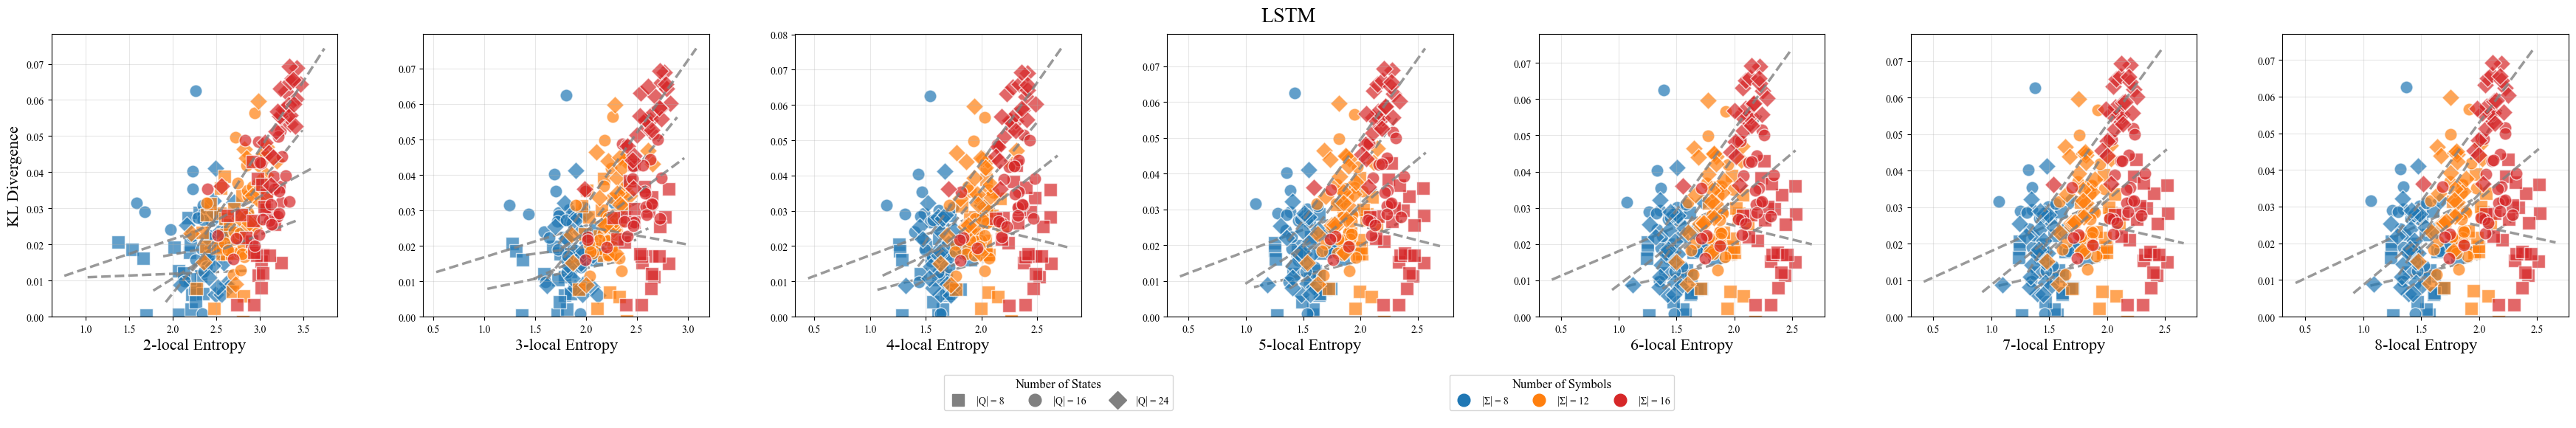

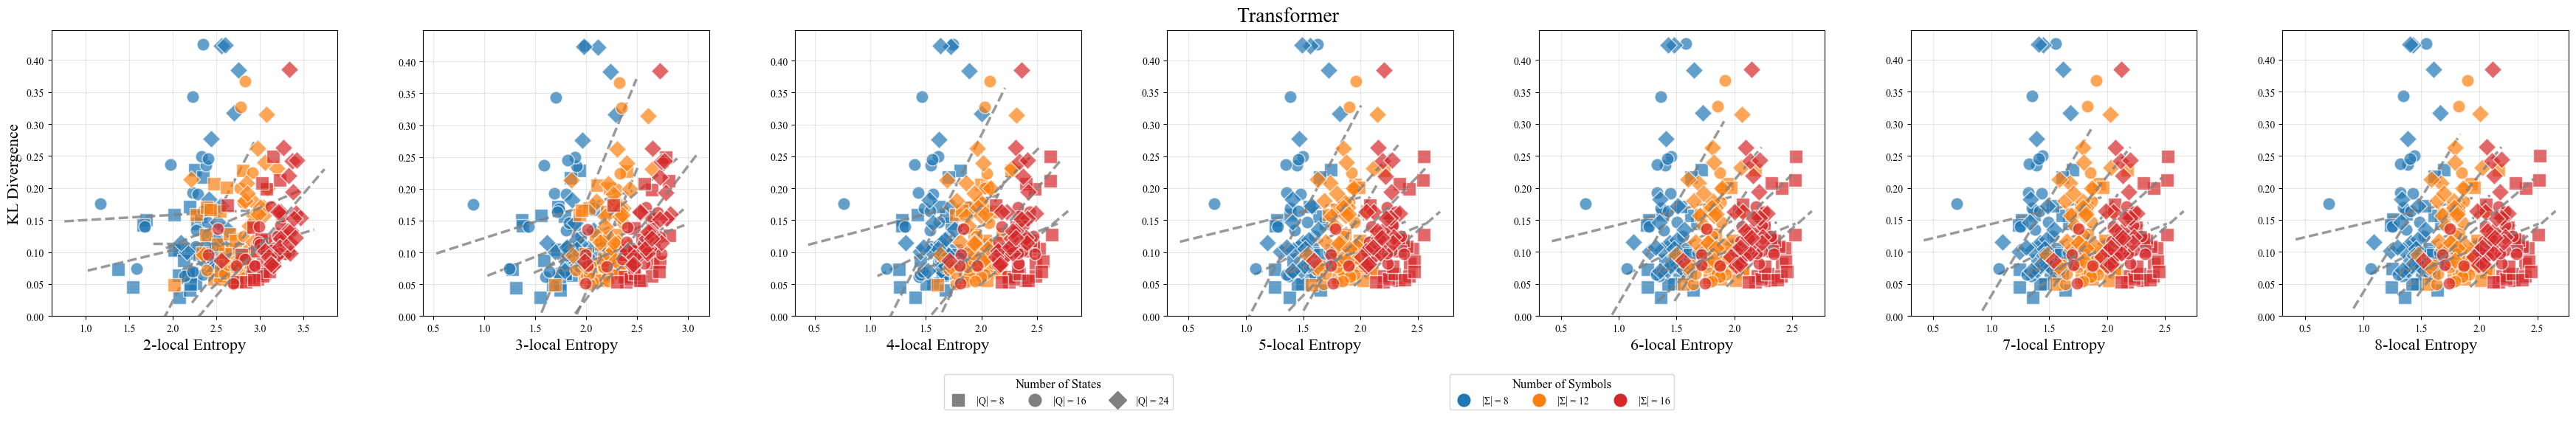

In [83]:
# Get m values from column names
ms = [
    int(col.replace("_local_entropy", ""))
    for col in df.columns
    if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
]

# Define markers and colors for different parameters
n_states_markers = {
    8: "s",
    16: "o",  # 円
    24: "D",  # ダイヤモンド
}

n_sym_colors = {
    8: "#1f77b4",  # 濃い青
    12: "#ff7f0e",  # 濃い橙
    16: "#d62728",  # 濃い赤
}

# n_states_markers = {
#     16: "o",    # 円
#     24: "D",   # ダイヤモンド
#     32: "s",   # 四角

# }

# n_sym_colors = {
#     32: "#1f77b4",  # 濃い青
#     48: "#ff7f0e",  # 濃い橙
#     64: "#d62728",  # 濃い赤
# }

for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    # キャンバスのサイズを調整
    fig = plt.figure(figsize=(5 * len(ms), 6))

    # グリッドを作成（2行1列）：上部にプロット、下部に凡例
    gs = fig.add_gridspec(2, 1, height_ratios=[5, 1])

    # 上部のグリッドをさらにサブプロットに分割
    gs_top = gs[0].subgridspec(1, len(ms), wspace=0.3)
    axes = [fig.add_subplot(gs_top[0, i]) for i in range(len(ms))]

    for i, m in enumerate(ms):
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        # Plot points and regression lines for each combination
        for n_sym in n_sym_colors.keys():
            for n_states in n_states_markers.keys():
                data = model_data_mean[
                    (model_data_mean["N_sym"] == n_sym)
                    & (model_data_mean["n_states"] == n_states)
                ]
                if not data.empty:
                    # Plot scatter points
                    axes[i].scatter(
                        data[f"{m}_local_entropy"],
                        data["KL_divergence"],
                        marker=n_states_markers[n_states],
                        color=n_sym_colors[n_sym],
                        s=150,
                        alpha=0.7,
                        edgecolor="white",
                        linewidth=1,
                    )

                    # Add regression line for this combination
                    x = data[f"{m}_local_entropy"]
                    y = data["KL_divergence"]
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

                    x_range = x.max() - x.min()
                    line_x = np.array(
                        [x.min() - 0.3 * x_range, x.max() + 0.3 * x_range]
                    )
                    line_y = slope * line_x + intercept
                    axes[i].plot(
                        line_x,
                        line_y,
                        color="gray",  # 統一した色
                        linestyle="--",
                        alpha=0.8,
                        linewidth=2.5,
                        zorder=1,
                    )

        axes[i].set_xlabel(f"{m}-local Entropy", fontsize=16)
        axes[i].set_ylabel("KL Divergence" if i == 0 else "", fontsize=16)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(
            0,
        )

    # 下部のグリッドに凡例を配置
    legend_ax = fig.add_subplot(gs[1])
    legend_ax.axis("off")  # 軸を非表示に

    # Create legend elements
    state_markers = [
        plt.Line2D(
            [0],
            [0],
            marker=marker,
            color="gray",
            markerfacecolor="gray",
            markersize=12,
            linestyle="None",
            label=f"|Q| = {n_states}",
        )
        for n_states, marker in n_states_markers.items()
    ]

    sym_markers = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=color,
            markersize=12,
            linestyle="None",
            label=f"|Σ| = {n_sym}",
        )
        for n_sym, color in n_sym_colors.items()
    ]

    # Add legends side by side with horizontal arrangement of elements
    legend1 = legend_ax.legend(
        handles=state_markers,
        title="Number of States",
        loc="center",
        bbox_to_anchor=(0.4, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_states_markers),
    )
    legend_ax.add_artist(legend1)

    legend2 = legend_ax.legend(
        handles=sym_markers,
        title="Number of Symbols",
        loc="center",
        bbox_to_anchor=(0.6, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_sym_colors),
    )

    plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.96)
    plt.tight_layout()
    plt.show()

In [49]:
# Calculate R² values and create LaTeX table
results = []
for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    for m in ms:
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        for n_sym in sorted(n_sym_colors.keys()):
            for n_states in sorted(n_states_markers.keys()):
                data = model_data_mean[
                    (model_data_mean["N_sym"] == n_sym)
                    & (model_data_mean["n_states"] == n_states)
                ]
                if not data.empty:
                    x = data[f"{m}_local_entropy"]
                    y = data["KL_divergence"]
                    _, _, r_value, _, _ = stats.linregress(x, y)
                    r_squared = r_value**2

                    results.append(
                        {
                            "Architecture": architecture_map[architecture],
                            "m": m,
                            "|Q|": n_states,
                            "|Σ|": n_sym,
                            "R²": r_squared,
                        }
                    )

results_df = pd.DataFrame(results)

# Create pivot table
pivot_df = results_df.pivot_table(
    index=["Architecture", "m"], columns=["|Q|", "|Σ|"], values="R²"
)

# Convert to LaTeX with specific formatting
latex_table = pivot_df.round(3).to_latex(
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True,
    float_format=lambda x: f"{x:.3f}" if pd.notnull(x) else "",
)

# Print LaTeX table
print(latex_table)

\begin{tabular}{llrrrrrrrrr}
\toprule
 & |Q| & \multicolumn{3}{c}{16} & \multicolumn{3}{c}{24} & \multicolumn{3}{c}{32} \\
 & |Σ| & 32 & 48 & 64 & 32 & 48 & 64 & 32 & 48 & 64 \\
Architecture & m &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{\textbf{LSTM}} & \textbf{2} & 0.433 & 0.501 & 0.137 & 0.291 & 0.583 & 0.121 & 0.423 & 0.311 & 0.623 \\
\textbf{} & \textbf{3} & 0.396 & 0.532 & 0.230 & 0.291 & 0.488 & 0.119 & 0.460 & 0.274 & 0.702 \\
\textbf{} & \textbf{4} & 0.412 & 0.546 & 0.236 & 0.311 & 0.477 & 0.122 & 0.474 & 0.283 & 0.702 \\
\textbf{} & \textbf{5} & 0.415 & 0.554 & 0.234 & 0.338 & 0.472 & 0.120 & 0.466 & 0.283 & 0.686 \\
\cline{1-11}
\multirow[t]{4}{*}{\textbf{Transformer}} & \textbf{2} & 0.740 & 0.679 & 0.455 & 0.290 & 0.658 & 0.844 & 0.551 & 0.622 & 0.709 \\
\textbf{} & \textbf{3} & 0.743 & 0.728 & 0.569 & 0.374 & 0.735 & 0.859 & 0.693 & 0.832 & 0.820 \\
\textbf{} & \textbf{4} & 0.737 & 0.674 & 0.549 & 0.389 & 0.727 & 0.844 & 0.668 & 0.848 & 0.799 \\
\textbf{} & 

## main figure


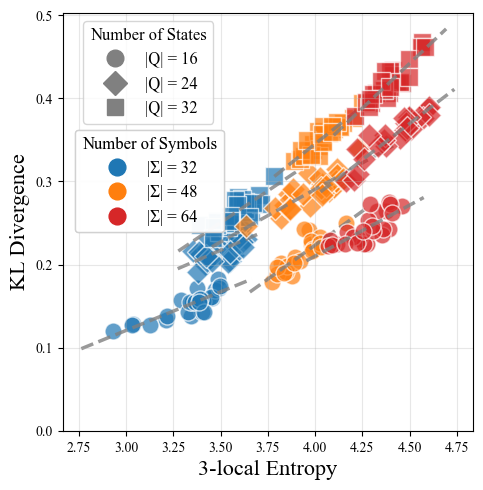

In [76]:
# Get m values from column names
# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

architecture = "transformer"
m = 3

ms = [
    int(col.replace("_local_entropy", ""))
    for col in df.columns
    if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
]

# Define markers and colors for different parameters
n_states_markers = {
    16: "o",  # Circle
    24: "D",  # Diamond
    32: "s",  # Square
}

n_sym_colors = {
    32: "#1f77b4",  # Dark Blue
    48: "#ff7f0e",  # Dark Orange
    64: "#d62728",  # Dark Red
}

model_data = df[df["architecture"] == architecture]

model_data_mean = (
    model_data.groupby(["grammar_name", "N_sym", "n_states"])
    .agg(
        {
            f"{m}_local_entropy": "mean",
            "KL_divergence": "mean",
        }
    )
    .reset_index()
)

plt.figure(figsize=(5, 5))

# Plot points and regression lines for each combination
for n_sym in n_sym_colors.keys():
    for n_states in n_states_markers.keys():
        data = model_data_mean[
            (model_data_mean["N_sym"] == n_sym)
            & (model_data_mean["n_states"] == n_states)
        ]
        if not data.empty:
            # Calculate IQR for KL_divergence
            Q1_y, Q3_y = np.percentile(data["KL_divergence"], [25, 75])
            IQR_y = Q3_y - Q1_y
            lower_bound_y = Q1_y - 1.5 * IQR_y
            upper_bound_y = Q3_y + 1.5 * IQR_y

            # Filter out outliers
            mask = (data["KL_divergence"] >= lower_bound_y) & (
                data["KL_divergence"] <= upper_bound_y
            )
            filtered_data = data[mask]

            if not filtered_data.empty:
                # Plot scatter points
                plt.scatter(
                    filtered_data[f"{m}_local_entropy"],
                    filtered_data["KL_divergence"],
                    marker=n_states_markers[n_states],
                    color=n_sym_colors[n_sym],
                    s=150,
                    alpha=0.7,
                    edgecolor="white",
                    linewidth=1,
                )

                # Add regression line for this combination
                x = filtered_data[f"{m}_local_entropy"]
                y = filtered_data["KL_divergence"]
                if len(x) > 2:  # Need at least 3 points for meaningful regression
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                    x_range = x.max() - x.min()
                    line_x = np.array(
                        [x.min() - 0.3 * x_range, x.max() + 0.3 * x_range]
                    )
                    line_y = slope * line_x + intercept
                    plt.plot(
                        line_x,
                        line_y,
                        color="gray",
                        linestyle="--",
                        alpha=0.8,
                        linewidth=2.5,
                        zorder=1,
                    )

state_markers = [
    plt.Line2D(
        [0],
        [0],
        marker=marker,
        color="gray",
        markerfacecolor="gray",
        markersize=12,  # Smaller marker size
        linestyle="None",
        label=f"|Q| = {n_states}",
    )
    for n_states, marker in n_states_markers.items()
]

sym_markers = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color=color,
        markersize=12,  # Smaller marker size
        linestyle="None",
        label=f"|Σ| = {n_sym}",
    )
    for n_sym, color in n_sym_colors.items()
]

# Add legends inside the figure ensuring they don't overlap
legend1 = plt.legend(
    handles=state_markers,
    title="Number of States",
    loc="upper left",
    bbox_to_anchor=(0.03, 1),
    fontsize=12,  # Smaller font size
    title_fontsize=12,  # Smaller title font size
    ncol=1,
)  # Set number of columns to 1

legend2 = plt.legend(
    handles=sym_markers,
    title="Number of Symbols",
    loc="upper left",
    bbox_to_anchor=(0.01, 0.74),  # Adjusted to prevent overlap
    fontsize=12,  # Smaller font size
    title_fontsize=12,  # Smaller title font size
    ncol=1,
)  # Set number of columns to 1

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.grid(True, alpha=0.3)
plt.xlabel(f"{m}-local Entropy", fontsize=16)
plt.ylabel("KL Divergence", fontsize=16)
# plt.title("Relationship between Local Entropy and KL Divergence", fontsize=18)  # Added figure title
plt.tight_layout()
plt.ylim(
    0,
)
plt.show()

/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/2435944920.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['m'] = m
/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/2435944920.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['architecture'] = architecture
/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/2435944920.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

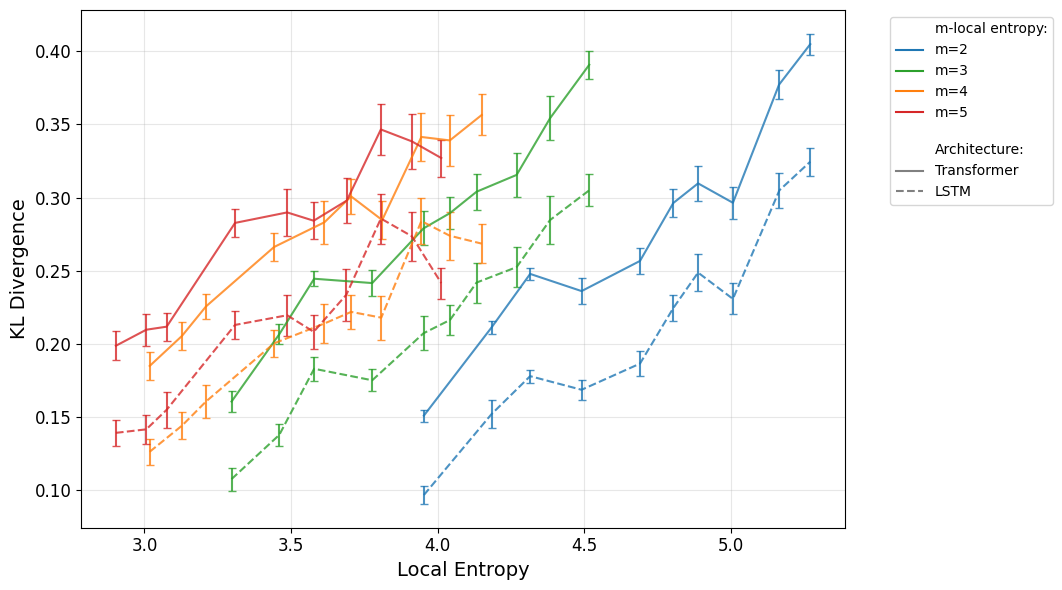

In [353]:
# Prepare data
combined_data = []
for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    for m in ms:
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        # Calculate IQR for KL_divergence
        Q1_y, Q3_y = np.percentile(model_data_mean["KL_divergence"], [25, 75])
        IQR_y = Q3_y - Q1_y
        lower_bound_y = Q1_y - 1.5 * IQR_y
        upper_bound_y = Q3_y + 1.5 * IQR_y

        # Filter outliers
        filtered_data = model_data_mean[
            (model_data_mean["KL_divergence"] >= lower_bound_y)
            & (model_data_mean["KL_divergence"] <= upper_bound_y)
        ]

        # Add to combined data
        filtered_data["m"] = m
        filtered_data["architecture"] = architecture
        combined_data.append(filtered_data)

combined_df = pd.concat(combined_data)

# Create bins for local entropy
n_bins = 10
for m in ms:
    combined_df[f"{m}_local_entropy_bins"] = pd.qcut(
        combined_df[f"{m}_local_entropy"], q=n_bins, labels=False
    )

# Calculate mean KL divergence for each bin
binned_data = []
for architecture in df["architecture"].unique():
    for m in ms:
        arch_m_data = combined_df[
            (combined_df["architecture"] == architecture) & (combined_df["m"] == m)
        ]

        bin_means = (
            arch_m_data.groupby(f"{m}_local_entropy_bins")
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": ["mean", "std", "count"],
                }
            )
            .reset_index()
        )

        bin_means["architecture"] = architecture
        bin_means["m"] = m
        binned_data.append(bin_means)

binned_df = pd.concat(binned_data)

# Define colors for m values
m_colors = {
    2: "#1f77b4",  # 青
    3: "#2ca02c",  # 緑
    4: "#ff7f0e",  # オレンジ
    5: "#d62728",  # 赤
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot lines and error bars
for m in ms:
    for arch in df["architecture"].unique():
        data = binned_df[(binned_df["architecture"] == arch) & (binned_df["m"] == m)]

        plt.errorbar(
            data[f"{m}_local_entropy"]["mean"],
            data["KL_divergence"]["mean"],
            yerr=data["KL_divergence"]["std"] / np.sqrt(data["KL_divergence"]["count"]),
            color=m_colors[m],
            linestyle="--" if arch == "lstm" else "-",  # ここが重要
            capsize=3,
            alpha=0.8,
        )

# Create combined legend elements
legend_elements = []

# Add m-local entropy elements
legend_elements.append(plt.Line2D([], [], color="none", label="m-local entropy:"))
legend_elements.extend(
    [plt.Line2D([0], [0], color=color, label=f"m={m}") for m, color in m_colors.items()]
)

# Add architecture elements
legend_elements.append(plt.Line2D([], [], color="none", label="\nArchitecture:"))
legend_elements.extend(
    [
        plt.Line2D([0], [0], color="gray", linestyle="-", label="Transformer"),
        plt.Line2D([0], [0], color="gray", linestyle="--", label="LSTM"),
    ]
)

# Add legend
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xlabel("Local Entropy", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis="both", which="major", labelsize=12)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()

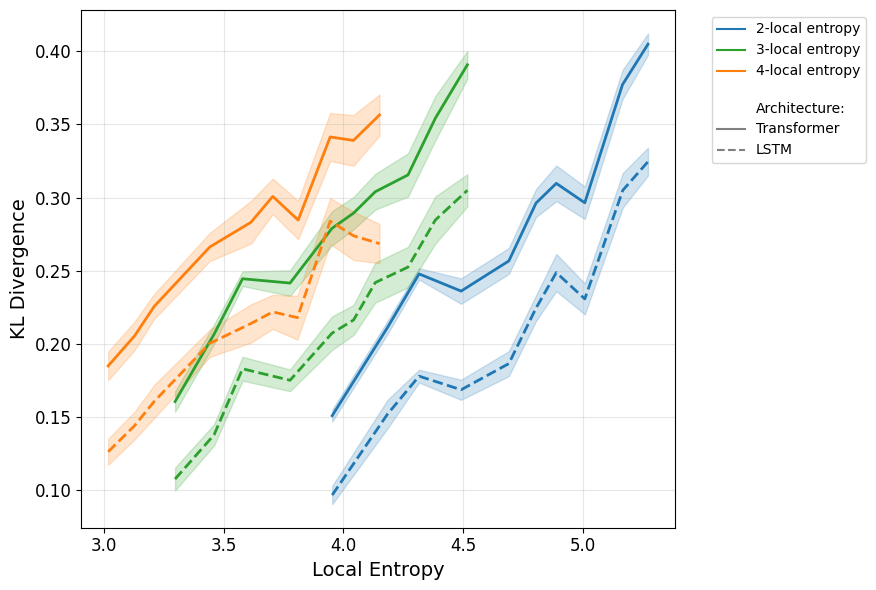

In [354]:
# Previous data preparation code remains the same until plotting

# Define colors for m values
m_colors = {
    2: "#1f77b4",  # 青
    3: "#2ca02c",  # 緑
    4: "#ff7f0e",  # オレンジ
    5: "#d62728",  # 赤
}
ms = [2, 3, 4]

# Create the plot
plt.figure(figsize=(8, 6))

# Plot lines and confidence areas
for m in ms:
    for arch in df["architecture"].unique():
        data = binned_df[(binned_df["architecture"] == arch) & (binned_df["m"] == m)]

        # Calculate standard error
        stderr = data["KL_divergence"]["std"] / np.sqrt(data["KL_divergence"]["count"])

        # Plot main line
        plt.plot(
            data[f"{m}_local_entropy"]["mean"],
            data["KL_divergence"]["mean"],
            color=m_colors[m],
            linestyle="--" if arch == "lstm" else "-",
            linewidth=2,
            zorder=2,  # Ensure lines are drawn above the confidence areas
        )

        # Plot confidence area
        plt.fill_between(
            data[f"{m}_local_entropy"]["mean"],
            data["KL_divergence"]["mean"] - stderr,
            data["KL_divergence"]["mean"] + stderr,
            color=m_colors[m],
            alpha=0.2,
            zorder=1,
        )

# Create combined legend elements
legend_elements = []

# Add m-local entropy elements
# legend_elements.append(plt.Line2D([], [], color='none', label='m-local entropy:'))
legend_elements.extend(
    [
        plt.Line2D([0], [0], color=color, label=f"{m}-local entropy")
        for m, color in m_colors.items()
        if m in ms
    ]
)

# Add architecture elements
legend_elements.append(plt.Line2D([], [], color="none", label="\nArchitecture:"))
legend_elements.extend(
    [
        plt.Line2D([0], [0], color="gray", linestyle="-", label="Transformer"),
        plt.Line2D([0], [0], color="gray", linestyle="--", label="LSTM"),
    ]
)

# Add legend
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")


plt.xlabel("Local Entropy", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis="both", which="major", labelsize=12)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()

/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/3794116973.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['m'] = m
/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/3794116973.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['architecture'] = architecture
/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/3794116973.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

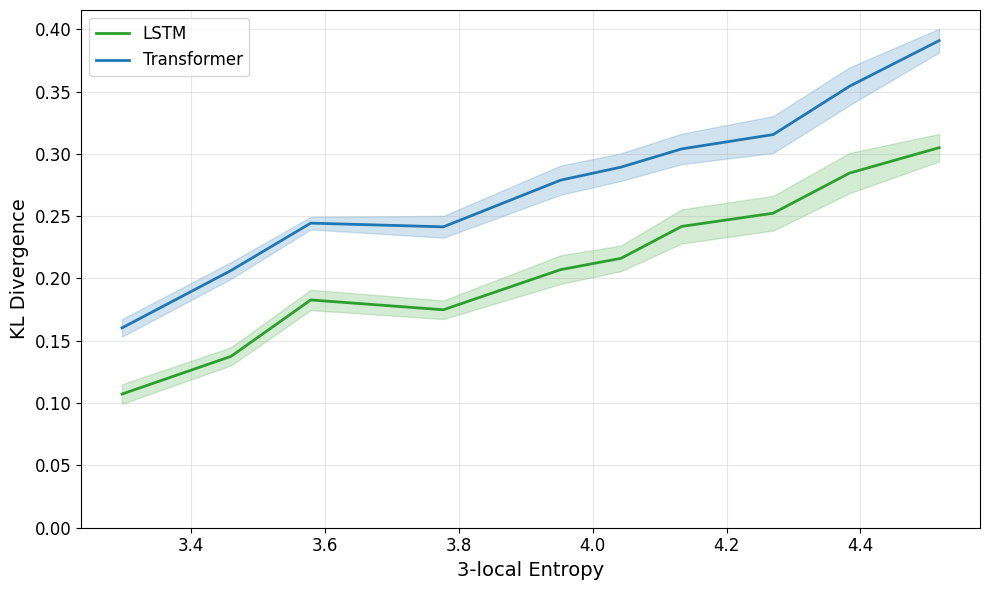

In [355]:
# Previous data preparation code remains the same until plotting
# Prepare data
combined_data = []
for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    for m in ms:
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        # Calculate IQR for KL_divergence
        Q1_y, Q3_y = np.percentile(model_data_mean["KL_divergence"], [25, 75])
        IQR_y = Q3_y - Q1_y
        lower_bound_y = Q1_y - 1.5 * IQR_y
        upper_bound_y = Q3_y + 1.5 * IQR_y

        # Filter outliers
        filtered_data = model_data_mean[
            (model_data_mean["KL_divergence"] >= lower_bound_y)
            & (model_data_mean["KL_divergence"] <= upper_bound_y)
        ]

        # Add to combined data
        filtered_data["m"] = m
        filtered_data["architecture"] = architecture
        combined_data.append(filtered_data)

combined_df = pd.concat(combined_data)

# Create bins for local entropy
n_bins = 10
for m in ms:
    combined_df[f"{m}_local_entropy_bins"] = pd.qcut(
        combined_df[f"{m}_local_entropy"], q=n_bins, labels=False
    )

# Calculate mean KL divergence for each bin
binned_data = []
for architecture in df["architecture"].unique():
    for m in ms:
        arch_m_data = combined_df[
            (combined_df["architecture"] == architecture) & (combined_df["m"] == m)
        ]

        bin_means = (
            arch_m_data.groupby(f"{m}_local_entropy_bins")
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": ["mean", "std", "count"],
                }
            )
            .reset_index()
        )

        bin_means["architecture"] = architecture
        bin_means["m"] = m
        binned_data.append(bin_means)

binned_df = pd.concat(binned_data)

target_m = 3

# Define colors for architectures
arch_colors = {"lstm": "#2ca02c", "transformer": "#1f77b4"}  # 緑  # 青

# Create the plot
plt.figure(figsize=(10, 6))

# Plot lines and confidence areas for m=4 only
for arch in df["architecture"].unique():
    data = binned_df[(binned_df["architecture"] == arch) & (binned_df["m"] == target_m)]

    # Calculate standard error
    stderr = data["KL_divergence"]["std"] / np.sqrt(data["KL_divergence"]["count"])

    # Plot main line
    plt.plot(
        data[f"{target_m}_local_entropy"]["mean"],
        data["KL_divergence"]["mean"],
        color=arch_colors[arch],
        linestyle="-",
        linewidth=2,
        label=f"{architecture_map[arch]}",
        zorder=2,  # Ensure lines are drawn above the confidence areas
    )

    # Plot confidence area
    plt.fill_between(
        data[f"{target_m}_local_entropy"]["mean"],
        data["KL_divergence"]["mean"] - stderr,
        data["KL_divergence"]["mean"] + stderr,
        color=arch_colors[arch],
        alpha=0.2,
        zorder=1,
    )

# Create legend
plt.legend(fontsize=12)

plt.ylim(
    0,
)
plt.xlabel(f"{target_m}-local Entropy", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis="both", which="major", labelsize=12)

# Adjust layout
plt.tight_layout()

plt.show()

### natural language


In [365]:
# Define the paths and parameters directly for notebook usage
exp_name = "BLLIP_SM"
# exp_name = "babylm2024_100K_sents"

# results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test.csv"
results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test_mlocal_entropy.csv"

output_dir = "plots"
architectures = ["transformer", "lstm"]
architecture_labels = ["Transformer", "LSTM"]
split_name = "test"

df = pd.read_csv(results_path)
df["experiment_name"] = df["grammar_name"].apply(get_experiment_name)
df["seed"] = df["grammar_name"].apply(get_seed)
df["window"] = df["grammar_name"].apply(get_window)

architecture_map = dict(zip(architectures, architecture_labels))

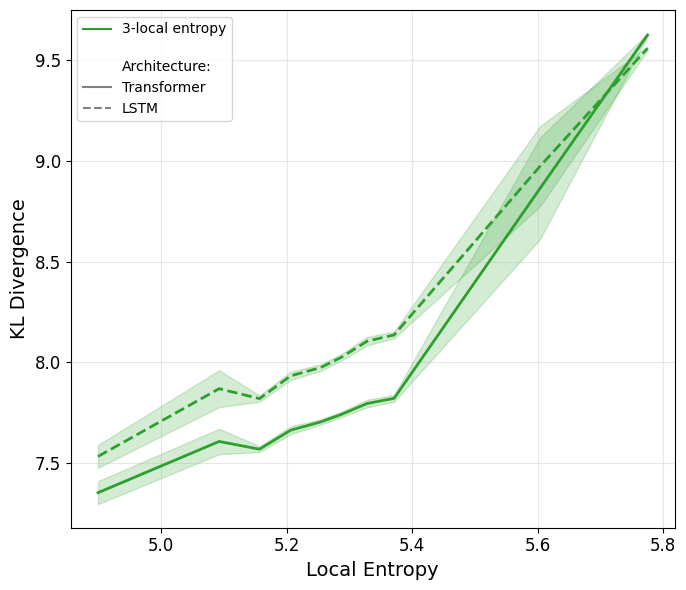

In [366]:
# Pre-filter outliers for each experiment type
ms = [3]
n_bins = 10


filtered_df = pd.DataFrame()  # 空のデータフレームを作成

for architecture in df["architecture"].unique():
    arch_data = df[df["architecture"] == architecture]

    # Base experiments and other non-window experiments
    for exp_name in [
        "Base",
        "EvenOddShuffle",
        "OddEvenShuffle",
        "Reverse",
        "DeterministicShuffle",
    ]:
        exp_data = arch_data[arch_data["experiment_name"] == exp_name]
        if not exp_data.empty:
            # Calculate IQR for this specific experiment
            Q1, Q3 = np.percentile(exp_data["cross_entropy_per_token_base_2"], [25, 75])
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter outliers
            exp_filtered = exp_data[
                (exp_data["cross_entropy_per_token_base_2"] >= lower_bound)
                & (exp_data["cross_entropy_per_token_base_2"] <= upper_bound)
            ]

            # Add filtered data to the new dataframe
            filtered_df = pd.concat([filtered_df, exp_filtered])

    # LocalShuffle experiments (filter for each window size)
    local_data = arch_data[
        arch_data["experiment_name"].str.contains("LocalShuffle", na=False)
    ]
    if not local_data.empty:
        for window in local_data["window"].unique():
            window_data = local_data[local_data["window"] == window]

            # Calculate IQR for this specific window size
            Q1, Q3 = np.percentile(
                window_data["cross_entropy_per_token_base_2"], [25, 75]
            )
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter outliers
            window_filtered = window_data[
                (window_data["cross_entropy_per_token_base_2"] >= lower_bound)
                & (window_data["cross_entropy_per_token_base_2"] <= upper_bound)
            ]

            # Add filtered data to the new dataframe
            filtered_df = pd.concat([filtered_df, window_filtered])


# Prepare data
combined_data = []
for architecture in filtered_df["architecture"].unique():
    model_data = filtered_df[filtered_df["architecture"] == architecture]

    for m in ms:
        model_data_mean = (
            model_data.groupby(["grammar_name"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "cross_entropy_per_token_base_2": "mean",
                }
            )
            .reset_index()
        )

        # Add to combined data
        model_data_mean["m"] = m
        model_data_mean["architecture"] = architecture
        combined_data.append(model_data_mean)

combined_df = pd.concat(combined_data)

# Create bins for local entropy
for m in ms:
    combined_df[f"{m}_local_entropy_bins"] = pd.qcut(
        combined_df[f"{m}_local_entropy"], q=n_bins, labels=False
    )

# Calculate mean KL divergence for each bin
binned_data = []
for architecture in df["architecture"].unique():
    for m in ms:
        arch_m_data = combined_df[
            (combined_df["architecture"] == architecture) & (combined_df["m"] == m)
        ]

        bin_means = (
            arch_m_data.groupby(f"{m}_local_entropy_bins")
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "cross_entropy_per_token_base_2": ["mean", "std", "count"],
                }
            )
            .reset_index()
        )

        bin_means["architecture"] = architecture
        bin_means["m"] = m
        binned_data.append(bin_means)

binned_df = pd.concat(binned_data)


# Define colors for m values
m_colors = {
    2: "#1f77b4",  # 青
    3: "#2ca02c",  # 緑
    4: "#ff7f0e",  # オレンジ
    5: "#d62728",  # 赤
}

# Create the plot
plt.figure(figsize=(8, 6))

# Plot lines and confidence areas
for m in ms:
    for arch in df["architecture"].unique():
        data = binned_df[(binned_df["architecture"] == arch) & (binned_df["m"] == m)]

        # Calculate standard error
        stderr = data["cross_entropy_per_token_base_2"]["std"] / np.sqrt(
            data["cross_entropy_per_token_base_2"]["count"]
        )

        # Plot main line
        plt.plot(
            data[f"{m}_local_entropy"]["mean"],
            data["cross_entropy_per_token_base_2"]["mean"],
            color=m_colors[m],
            linestyle="--" if arch == "lstm" else "-",
            linewidth=2,
            zorder=2,  # Ensure lines are drawn above the confidence areas
        )

        # Plot confidence area
        plt.fill_between(
            data[f"{m}_local_entropy"]["mean"],
            data["cross_entropy_per_token_base_2"]["mean"] - stderr,
            data["cross_entropy_per_token_base_2"]["mean"] + stderr,
            color=m_colors[m],
            alpha=0.2,
            zorder=1,
        )
        # plt.ylim(0, )

# Create combined legend elements
legend_elements = []

# Add m-local entropy elements
# legend_elements.append(plt.Line2D([], [], color='none', label='m-local entropy:'))
legend_elements.extend(
    [
        plt.Line2D([0], [0], color=color, label=f"{m}-local entropy")
        for m, color in m_colors.items()
        if m in ms
    ]
)

# Add architecture elements
legend_elements.append(plt.Line2D([], [], color="none", label="\nArchitecture:"))
legend_elements.extend(
    [
        plt.Line2D([0], [0], color="gray", linestyle="-", label="Transformer"),
        plt.Line2D([0], [0], color="gray", linestyle="--", label="LSTM"),
    ]
)

# Add legend
plt.legend(
    handles=legend_elements,
    #   bbox_to_anchor=(1.05, 1),
    loc="upper left",
)


plt.xlabel("Local Entropy", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis="both", which="major", labelsize=12)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()

/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/3171249686.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['m'] = m
/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/3171249686.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['architecture'] = architecture
/var/folders/yc/6mgsr29j59n50dk93bwtsb1c0000gn/T/ipykernel_35258/3171249686.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

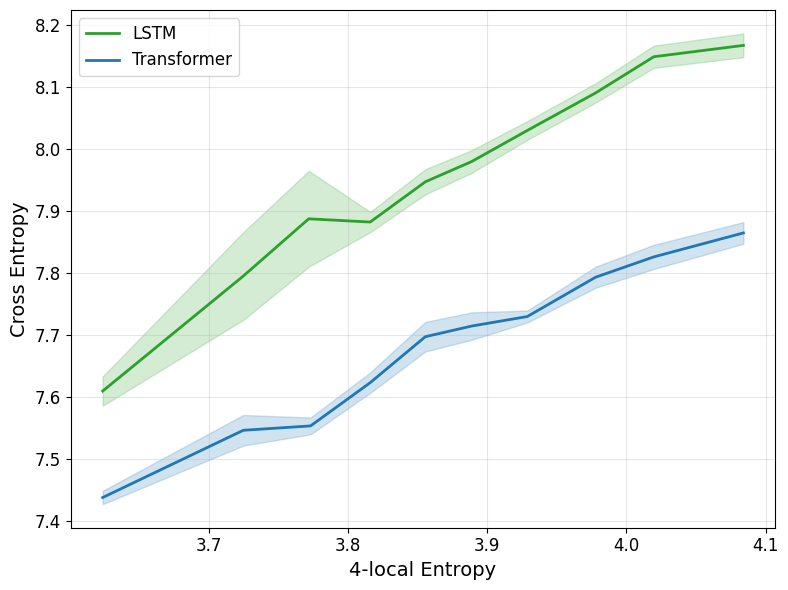

In [377]:
# Previous data preparation code remains the same until plotting
# Prepare data

ms = [2, 3, 4, 5]
target_m = 4

combined_data = []
for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    for m in ms:
        model_data_mean = (
            model_data.groupby(["grammar_name"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "cross_entropy_per_token_base_2": "mean",
                }
            )
            .reset_index()
        )

        # Calculate IQR for cross_entropy_per_token_base_2
        Q1_y, Q3_y = np.percentile(
            model_data_mean["cross_entropy_per_token_base_2"], [25, 75]
        )
        IQR_y = Q3_y - Q1_y
        lower_bound_y = Q1_y - 1.5 * IQR_y
        upper_bound_y = Q3_y + 1.5 * IQR_y

        # Filter outliers
        filtered_data = model_data_mean[
            (model_data_mean["cross_entropy_per_token_base_2"] >= lower_bound_y)
            & (model_data_mean["cross_entropy_per_token_base_2"] <= upper_bound_y)
        ]

        # Add to combined data
        filtered_data["m"] = m
        filtered_data["architecture"] = architecture
        combined_data.append(filtered_data)

combined_df = pd.concat(combined_data)

# Create bins for local entropy
n_bins = 10
for m in ms:
    combined_df[f"{m}_local_entropy_bins"] = pd.qcut(
        combined_df[f"{m}_local_entropy"], q=n_bins, labels=False
    )

# Calculate mean KL divergence for each bin
binned_data = []
for architecture in df["architecture"].unique():
    for m in ms:
        arch_m_data = combined_df[
            (combined_df["architecture"] == architecture) & (combined_df["m"] == m)
        ]

        bin_means = (
            arch_m_data.groupby(f"{m}_local_entropy_bins")
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "cross_entropy_per_token_base_2": ["mean", "std", "count"],
                }
            )
            .reset_index()
        )

        bin_means["architecture"] = architecture
        bin_means["m"] = m
        binned_data.append(bin_means)

binned_df = pd.concat(binned_data)


# Define colors for architectures
arch_colors = {"lstm": "#2ca02c", "transformer": "#1f77b4"}  # 緑  # 青

# Create the plot
plt.figure(figsize=(8, 6))

# Plot lines and confidence areas for m=4 only
for arch in df["architecture"].unique():
    data = binned_df[(binned_df["architecture"] == arch) & (binned_df["m"] == target_m)]

    # Calculate standard error
    stderr = data["cross_entropy_per_token_base_2"]["std"] / np.sqrt(
        data["cross_entropy_per_token_base_2"]["count"]
    )

    # Plot main line
    plt.plot(
        data[f"{target_m}_local_entropy"]["mean"],
        data["cross_entropy_per_token_base_2"]["mean"],
        color=arch_colors[arch],
        linestyle="-",
        linewidth=2,
        label=f"{architecture_map[arch]}",
        zorder=2,  # Ensure lines are drawn above the confidence areas
    )

    # Plot confidence area
    plt.fill_between(
        data[f"{target_m}_local_entropy"]["mean"],
        data["cross_entropy_per_token_base_2"]["mean"] - stderr,
        data["cross_entropy_per_token_base_2"]["mean"] + stderr,
        color=arch_colors[arch],
        alpha=0.2,
        zorder=1,
    )

# Create legend
plt.legend(fontsize=12)

plt.xlabel(f"{target_m}-local Entropy", fontsize=14)
plt.ylabel("Cross Entropy", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis="both", which="major", labelsize=12)

# Adjust layout
plt.tight_layout()

plt.show()